In [33]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from marbleri.models import BaseConvNet
from marbleri.process import get_hwrf_filenames
from marbleri.nwp import HWRFStep, BestTrackNetCDF
from sklearn.metrics import mean_absolute_error
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
from glob import glob
from os.path import join, exists
import pandas as pd
from matplotlib.colors import LogNorm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import save_model
from marbleri.training import partition_storm_examples
from dask.distributed import LocalCluster, Client

%matplotlib inline


In [2]:
print(tf.__version__)

2.0.0


In [2]:
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(tf.config.experimental.list_physical_devices())
except AttributeError:
    tf_config = tf.ConfigProto()
    tf_config.gpu_options.allow_growth = True
    K.set_session(tf.Session(config=tf_config))


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]


In [3]:
bt_nc = BestTrackNetCDF(file_path="/glade/p/ral/allral/dgagne/hfip/processed_data/best_track_dv/")


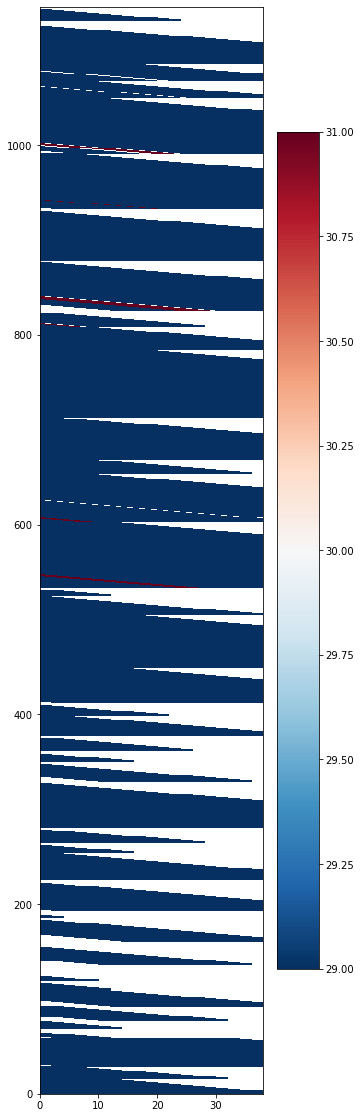

In [107]:
plt.figure(figsize=(5, 20))
plt.pcolormesh(bt_nc.bt_ds["l"]["vmax_bt_new"].T.values[:, 5:] - bt_nc.bt_ds["l"]["vmax_bt_new"].T.values[:, :-5], vmin=29, vmax=31, cmap="RdBu_r")
plt.colorbar()

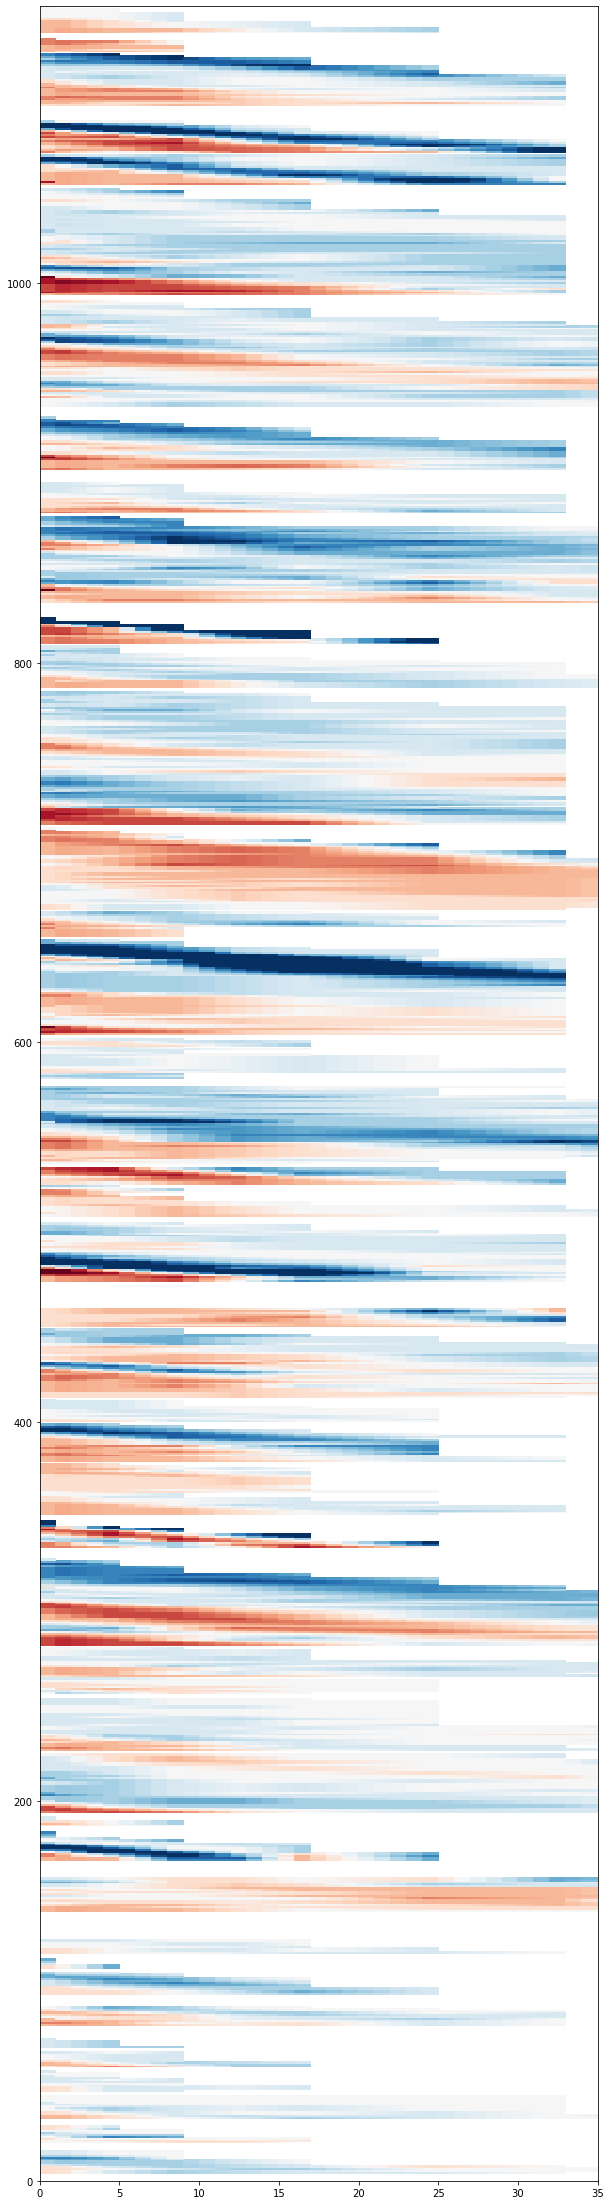

In [25]:
plt.figure(figsize=(10, 40))
plt.pcolormesh(bt_nc.bt_ds["l"]["vmax_nhc"].T.values[:, 8:] - bt_nc.bt_ds["l"]["vmax_nhc"].T.values[:, :-8], vmin=-30, vmax=30, cmap="RdBu_r")



In [27]:
nhc_vmax_diff = bt_nc.bt_ds["l"]["vmax_nhc"].T.values[:, 8:] - bt_nc.bt_ds["l"]["vmax_nhc"].T.values[:, :-8]

(array([  83.,  116.,  204.,  430.,  915., 1604., 4545., 6861., 5047.,
        2903., 2026.,  722.,  263.,   34.,    9.]),
 array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,
         25,  30,  35]),
 <a list of 15 Patch objects>)

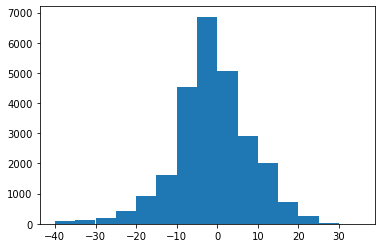

In [31]:
plt.hist(nhc_vmax_diff.ravel()[~np.isnan(nhc_vmax_diff.ravel())], bins=np.arange(-40, 40, 5))

In [63]:
offset = 8
vmax_hwrf_diff = bt_nc.bt_ds["l"]["vmax_hi_smoothed_3h"].T.values[:, offset:] - bt_nc.bt_ds["l"]["vmax_hi_smoothed_3h"].T.values[:, :-offset] 
vmax_nhc_diff = bt_nc.bt_ds["l"]["vmax_nhc"].T.values[:, offset:] - bt_nc.bt_ds["l"]["vmax_nhc"].T.values[:, :-offset] 

vmax_diff = bt_nc.bt_ds["l"]["vmax_bt_new"].T.values[:, offset:] - bt_nc.bt_ds["l"]["vmax_bt_new"].T.values[:, :-offset] 

In [ ]:
vmax_nhc_diff

In [99]:
np.count_nonzero(vmax_diff.ravel()[~np.isnan(vmax_diff.ravel())] > 30)

1427

In [50]:
valid = ~np.isnan(vmax_diff[:, 0])

In [49]:
vmax_hwrf_diff[:, 0]

array([-0.56204987,  6.08960533,  1.33958817, ..., -9.53649521,
       -6.05677032, -8.59235001])

In [84]:
droc_hwrf = DistributedROC(thresholds=np.arange(-20, 40, 5))
droc_hwrf.update(vmax_hwrf_diff[:, 0][valid], np.where(vmax_diff[valid, 0] > 0, 1, 0))
droc_nhc =  DistributedROC(thresholds=np.arange(-20, 40, 5))
valid_nhc = ~np.isnan(vmax_nhc_diff[:, 0]) & ~np.isnan(vmax_diff[:, 0])
droc_nhc.update(vmax_nhc_diff[:, 0][valid], np.where(vmax_diff[valid, 0] > 0, 1, 0))


In [85]:
roc_hwrf = droc_hwrf.roc_curve()
roc_nhc = droc_nhc.roc_curve()

In [73]:
roc_hwrf

,POD,POFD,Thresholds
0,1.000000,0.972270,-40
1,1.000000,0.958406,-35
2,1.000000,0.930676,-30
3,0.997585,0.890815,-25
4,0.995169,0.835355,-20
5,0.990338,0.766031,-15
6,0.966184,0.629116,-10
7,0.925121,0.497400,-5
8,0.838164,0.341421,0
9,0.700483,0.171577,5


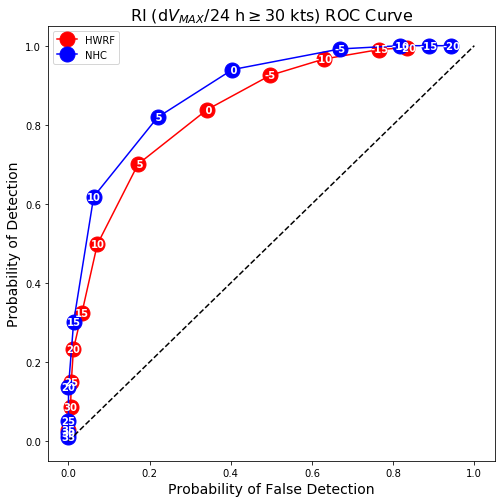

In [101]:
plt.figure(figsize=(8, 8))
plt.plot(roc_hwrf["POFD"], roc_hwrf["POD"], marker='o', ms=15, color='red', label="HWRF")
for t, thresh in enumerate(roc_hwrf["Thresholds"]):
    plt.text(roc_hwrf.loc[t, "POFD"], roc_hwrf.loc[t, "POD"], f"{thresh:2.0f}", ha="center", va="center", color='w', fontweight="bold")

plt.plot(roc_nhc["POFD"], roc_nhc["POD"], marker='o', ms=15, color="blue", label="NHC")
for t, thresh in enumerate(roc_nhc["Thresholds"]):
    plt.text(roc_nhc.loc[t, "POFD"], roc_nhc.loc[t, "POD"], f"{thresh:2.0f}", ha="center", va="center", color='w', fontweight="bold")
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')
plt.legend()
plt.title("RI (d$V_{MAX}$/24 h$\geq$30 kts) ROC Curve", fontsize=16)
plt.xlabel("Probability of False Detection", fontsize=14)
plt.ylabel("Probability of Detection", fontsize=14)
plt.savefig("HWRF_NHC_RI_ROC.png", dpi=200,  bbox_inches="tight")

In [12]:
bt_nc.bt_ds["l"]["VMAX"].shape

(43, 1146)

In [17]:
offset = 8
basin = "l"
vmax_vars = np.array(["vmax_bt_new", "vmax_hi_smoothed_3h", "vmax_nhc", "vmax_dshp"])
ri_counts = np.zeros((vmax_vars.size, bt_nc.bt_ds[basin]["VMAX"].shape[0]), dtype=np.int32)
print(ri_counts.shape[1])
for v, var in enumerate(vmax_vars):
    diff = bt_nc.bt_ds[basin][var].T.values[:, offset:] - bt_nc.bt_ds[basin][var].T.values[:, :-offset]
    print(diff.shape)
    for c in range(diff.shape[1]):
        ri_counts[v, c] = np.count_nonzero(diff[:, c][~np.isnan(diff[:, c])] >= 30)


43
(1146, 35)
(1146, 35)
(1146, 35)
(1146, 35)


In [10]:
for col in range(vmax_hwrf_diff.shape[1]):
    diff_0 = vmax_hwrf_diff[:, col]
    diff_0_sub = diff_0[~np.isnan(diff_0)]
    print(bt_nc.bt_ds["l"]["TIME"].values[col], np.count_nonzero(diff_0_sub >= 30))

0 49
3 45
6 40
9 40
12 38
15 42
18 38
21 35
24 34
27 31
30 41
33 38
36 36
39 39
42 42
45 39
48 32
51 35
54 32
57 20
60 19
63 15
66 10
69 10
72 8
75 8
78 5
81 5
84 7
87 8
90 8
93 8
96 6
99 7
102 0


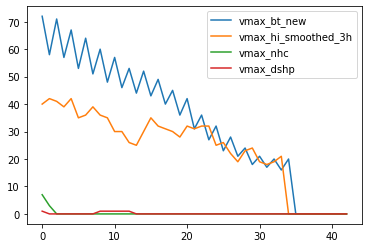

In [23]:
for r, model in enumerate(vmax_vars):
    plt.plot(ri_counts[r], label=model)
plt.legend()

In [93]:
vmax_diff.ravel()

array([5. , 2.5, 0. , ..., nan, nan, nan])

In [94]:
np.count_nonzero(diff_0_sub > 30)

81

In [47]:
bt_nc.bt_ds["l"]["TIME"]

<xarray.DataArray 'TIME' (time: 43)>
array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
        42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,  81,
        84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117, 120, 123,
       126], dtype=int32)
Dimensions without coordinates: time
Attributes:
    long_name:  Forecast_Time
    units:      h

In [39]:
bt_nc.bt_ds["l"]["dvmax_bt_12"].T.shape

(1146, 43)

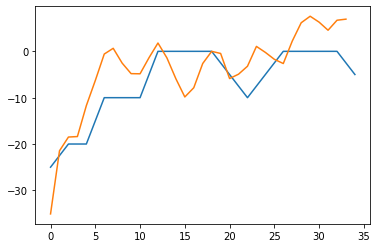

In [68]:
i = 201
plt.plot(vmax_diff[i])
dv = bt_nc.bt_ds["l"]["dvmax_bt_24"].T.values[i]
#plt.plot(np.where(dv < 1e10, dv, np.nan))
plt.plot(vmax_hwrf_diff[i])

In [21]:
bt_nc.bt_ds["l"]["VMAX"].T.values.shape

(1146, 43)

In [ ]:
plt.pcolormesh(bt_nc.bt_ds["l"]["VMAX"].T)

In [14]:
del bt_nc

In [19]:
bt_nc.bt_ds["l"]["TIME"]

<xarray.DataArray 'TIME' (time: 43)>
array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
        42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,  81,
        84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117, 120, 123,
       126], dtype=int32)
Dimensions without coordinates: time
Attributes:
    long_name:  Forecast_Time
    units:      h

In [18]:
bt_nc.bt_ds["l"]

<xarray.Dataset>
Dimensions:                 (TC quadrants: 4, run: 1146, time: 43)
Dimensions without coordinates: TC quadrants, run, time
Data variables:
    DATE                    (run) |S10 b'2015050700' ... b'2017110912'
    STNAM                   (run) |S10 b'invest    ' ... b'rina      '
    STNUM                   (run) |S2 b'01' b'01' b'01' ... b'19' b'19' b'19'
    BASIN                   (run) |S2 b'l ' b'l ' b'l ' ... b'l ' b'l ' b'l '
    TIME                    (time) int32 ...
    LAT                     (time, run) float32 ...
    LON                     (time, run) float32 ...
    VMAX                    (time, run) float32 ...
    RMW                     (time, run) float32 ...
    MIN_SLP                 (time, run) float32 ...
    SHR_MAG                 (time, run) float32 ...
    SHR_HDG                 (time, run) float32 ...
    STM_SPD                 (time, run) float32 ...
    STM_HDG                 (time, run) float32 ...
    SST                     (time

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [5]:
get_available_gpus()

['/device:GPU:0']

In [142]:
rank = 0
np.random.seed(2325)
best_track = pd.read_csv("/glade/scratch/dgagne/hfip/processed_data_dv_lossy/best_track_all.csv", index_col="Index")
print("original best track count", best_track.shape[0])
out_col = "dvmax_bt_12"
best_track = best_track.loc[np.abs(best_track[out_col]) < 1000, :].reset_index(drop=True)
print("filtered best track count", best_track.shape[0])
train_rank_indices, val_rank_indices = partition_storm_examples(best_track, 1,
                                                                0.4)

original best track count 51969
filtered best track count 48876


In [192]:
best_track.columns

Index(['DATE', 'STNAM', 'STNUM', 'BASIN', 'TIME', 'LON', 'LAT', 'VMAX', 'RMW',
       'MIN_SLP', 'SHR_MAG', 'SHR_HDG', 'STM_SPD', 'STM_HDG', 'SST', 'TPW',
       'LAND', 'TANG850', 'VORT850', 'DVRG200', 'RHLO', 'RHMD', 'RHHI',
       'CAPE1', 'CAPE2', 'CAPE3', 'LHTFL1', 'LHTFL2', 'LHTFL3', 'SHTFL1',
       'SHTFL2', 'SHTFL3', 'VMAXMPI', 'POTMPI', 'TGRD', 'IKE1', 'IKE2',
       'TCOND7001', 'TCOND7002', 'TCOND7003', 'TCONDALL1', 'TCONDALL2',
       'TCONDALL3', 'INST1', 'INST2', 'INST3', 'CP1', 'CP2', 'CP3',
       'TCONDSYM1', 'TCONDSYM2', 'TCONDSYM3', 'INERTSYM1', 'INERTSYM2',
       'INERTSYM3', 'COUPLSYM1', 'COUPLSYM2', 'COUPLSYM3', 'WALLA1', 'WALLA2',
       'WALLA3', 'WSYM1', 'WSYM2', 'WSYM3', 'USFC1', 'USFC2', 'USFC3',
       'USFCSYM1', 'USFCSYM2', 'USFCSYM3', 'vmax_bt_new', 'dvmax_bt_12',
       'dvmax_bt_24'],
      dtype='object')

In [143]:
hwrf_path = "/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/"
hwrf_files = get_hwrf_filenames(best_track, hwrf_path)

In [4]:
['THETA_E_L100',
 'THETA_E_L103',
 'TCOLC_E_L103',
 'U_RAD_L100',
 'U_RAD_L103',
 'V_TAN_L100',
 'V_TAN_L103',
 'SHR_HDG',
 'CENLAT',
 'CENLON',
 'y_0',
 'x_0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

['THETA_E_L100',
 'THETA_E_L103',
 'TCOLC_E_L103',
 'U_RAD_L100',
 'U_RAD_L103',
 'V_TAN_L100',
 'V_TAN_L103',
 'SHR_HDG',
 'CENLAT',
 'CENLON',
 'y_0',
 'x_0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

In [144]:
input_var_levels = []
#m_vars = ["THETA_E_L100", "U_RAD_L100", "V_TAN_L100"]
m_vars  = []
s_vars = ["THETA_E_L103", "U_RAD_L103", "V_TAN_L103", "TCOLC_E_L103"]
p_levs = [20000, 85000]
for m_var in m_vars:
    for p_lev in p_levs:
        input_var_levels.append((m_var, p_lev))
for s_var in s_vars:
    input_var_levels.append((s_var, None))

In [145]:
hwrf_exists = np.array([exists(hwrf_file) for hwrf_file in hwrf_files])

In [146]:
np.any(~hwrf_exists)

False

In [155]:
n_workers = 16

In [23]:
cluster = LocalCluster(n_workers=n_workers, threads_per_worker=1, memory_limit=16e9)
client = Client(cluster)

In [22]:
client.close()
cluster.close()

In [154]:
client.ncores

<bound method Client.nthreads of <Client: 'tcp://127.0.0.1:42550' processes=16 threads=16, memory=256.00 GB>>

In [24]:
def load_data(hwrf_file_list, input_var_levels=None):
    data = []
    step_data = []
    for t, train_file in enumerate(hwrf_file_list):
        step = HWRFStep(train_file)
        for var in input_var_levels:
            step_data.append(step.get_variable(var[0], level=var[1]).values)
        step.close()
        del step
        data.append(np.stack(step_data, axis=-1))
        del step_data[:]
    train_data = np.stack(data, axis=0)
    return train_data

In [148]:
hwrf_files[train_rank_indices[0]].shape

(27435,)

In [156]:
slice_indices = np.linspace(0, hwrf_files[train_rank_indices[0]].size, n_workers + 1).astype(int)
slice_indices

array([    0,  1714,  3429,  5144,  6858,  8573, 10288, 12002, 13717,
       15432, 17146, 18861, 20576, 22290, 24005, 25720, 27435])

In [157]:
hwrf_subsets = [hwrf_files[train_rank_indices[0]][slice_index:slice_indices[s + 1]] for s, slice_index in enumerate(slice_indices[:-1])]

In [159]:
out = client.map(load_data, hwrf_subsets, input_var_levels=input_var_levels)

In [169]:
out

[<Future: status: finished, type: ndarray, key: load_data-e77466542d5b32fecf949ef77d1afa7e>,
 <Future: status: finished, type: ndarray, key: load_data-406a4106904c783cdc8d61c520a8688e>,
 <Future: status: finished, type: ndarray, key: load_data-36e869baae9a78e89002b0b106b7e1c5>,
 <Future: status: finished, type: ndarray, key: load_data-084ed87a5e708161f590f999368eab5e>,
 <Future: status: finished, type: ndarray, key: load_data-39569f4122f374d4aef6c3472fafc7b4>,
 <Future: status: finished, type: ndarray, key: load_data-79f3fdbd1505099f9d885ecd15dfe90a>,
 <Future: status: finished, type: ndarray, key: load_data-d0ca90bfc27e60cb8a82bcd6ffde7a3a>,
 <Future: status: finished, type: ndarray, key: load_data-56ef0e3b0ebffb5a23733e2699637a4c>,
 <Future: status: finished, type: ndarray, key: load_data-c778e8974c06453db39e5f6bc52cc123>,
 <Future: status: finished, type: ndarray, key: load_data-8a33ae26248adaafba829757150ffd5a>,
 <Future: status: finished, type: ndarray, key: load_data-c7a1d1477516

In [170]:
train_data = np.vstack(client.gather(out))

In [171]:
val_slice_indices = np.linspace(0, hwrf_files[val_rank_indices[0]].size, n_workers + 1).astype(int)
hwrf_val_subsets = [hwrf_files[train_rank_indices[0]][slice_index:val_slice_indices[s + 1]] for s, slice_index in enumerate(val_slice_indices[:-1])]

In [172]:
val_out = client.map(load_data, hwrf_val_subsets, input_var_levels=input_var_levels)

In [185]:
val_out

[<Future: status: finished, type: ndarray, key: load_data-aab31376590ac396ed17f7fa42ee4afa>,
 <Future: status: finished, type: ndarray, key: load_data-3d33d434867c5fa41e1f686e61d45ebd>,
 <Future: status: finished, type: ndarray, key: load_data-a8f95c0e8872cd6d7992e44c8dbeeddf>,
 <Future: status: finished, type: ndarray, key: load_data-e83619d2db917411087ae3c68ad67d2f>,
 <Future: status: finished, type: ndarray, key: load_data-f36d36af5ea678ccfc5071460901c750>,
 <Future: status: finished, type: ndarray, key: load_data-1bfdb013ad8871001615d8a0abc6c519>,
 <Future: status: finished, type: ndarray, key: load_data-ea81d9a7428374114aec7a58c8ac0bb8>,
 <Future: status: finished, type: ndarray, key: load_data-bbe05d240d2271caa9cf89c09a709f7a>,
 <Future: status: finished, type: ndarray, key: load_data-d8c1233dc3ccf182dc71bdb78c9f6af4>,
 <Future: status: finished, type: ndarray, key: load_data-a35c6339fba599b1360fea38dda90bbf>,
 <Future: status: finished, type: ndarray, key: load_data-32314aeb7873

In [186]:
val_data = np.vstack(client.gather(val_out))

In [300]:
norm_train_data = np.zeros(train_data.shape, dtype=np.float32)
train_scaling = np.zeros((train_data.shape[-1], 2), dtype=np.float32)
for c in range(norm_train_data.shape[-1]):
    train_scaling[c, 0] = np.nanmax(train_data[:, :, :, c])
    train_scaling[c, 1] = np.nanmin(train_data[:, :, :, c])
    norm_train_data[:, :, :, c] = (train_data[:, :, :, c] - train_scaling[c, 1]) / (train_scaling[c, 0] - train_scaling[c, 1])
norm_train_data[np.isnan(train_data)] = 0

In [302]:
norm_train_data[:, :, :, 1:].min()

0.0

In [303]:
norm_val_data = np.zeros(val_data.shape, dtype=np.float32)
for c in range(norm_val_data.shape[-1]):
    norm_val_data[:, :, :, c] = (val_data[:, :, :, c] - train_scaling[c, 1]) / (train_scaling[c, 0] - train_scaling[c, 1])
norm_val_data[np.isnan(val_data)] = 0

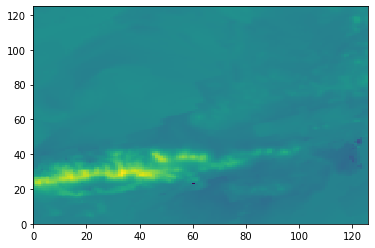

In [266]:
plt.pcolormesh(norm_val_data[12000, :, :, 0])

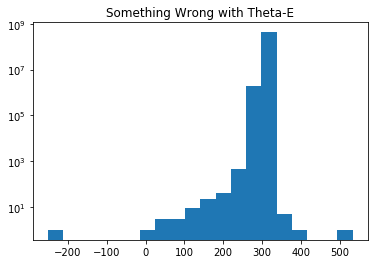

In [286]:

plt.hist(train_data[:, :, :, 0].ravel(), bins=20)
plt.title("Something Wrong with Theta-E")
plt.gca().set_yscale("log")
plt.savefig("theta_e_dist.png", dpi=200, bbox_inches="tight")

In [287]:
np.where(train_data[:, :, :, 0] > 400)

(array([12177, 12177]), array([33, 34]), array([19, 19]))

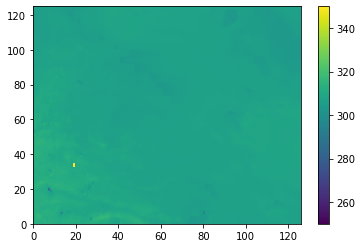

In [290]:
plt.pcolormesh(train_data[12177, :, :, 0], vmin=250, vmax=350)
plt.colorbar()
plt.savefig("high_theta_e.png", dpi=200, bbox_inches="tight")

In [249]:
from tensorflow.keras.layers import Dense, Conv2D, Activation, Input, Flatten, AveragePooling2D, MaxPool2D, LeakyReLU, Dropout, Add
from tensorflow.keras.layers import BatchNormalization, Concatenate, Layer, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, binary_crossentropy
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.regularizers import l2

class NormOut(Layer):
    def __init__(self, **kwargs):
        self.mean_dense = Dense(1, **kwargs)
        self.sd_dense = Dense(1, activation=K.exp, **kwargs)
        super(NormOut, self).__init__()

    def call(self, inputs, **kwargs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        return Concatenate()([mean_x, sd_x])

    def compute_output_shape(self, input_shape):
        return input_shape[0], 2


class GaussianMixtureOut(Layer):
    def __init__(self, mixtures=2, **kwargs):
        self.mixtures = mixtures
        self.mean_dense = Dense(self.mixtures, activation="relu", **kwargs)
        self.sd_dense = Dense(self.mixtures, activation=K.exp, **kwargs)
        self.weight_dense = Dense(self.mixtures, activation="softmax", **kwargs)
        super(GaussianMixtureOut, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        weights_x = self.weight_dense(inputs)
        return Concatenate()([mean_x, sd_x, weights_x])

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.mixtures * 3


def crps_norm(y_true, y_pred, cdf_points=np.arange(-200, 200.0, 1.0)):
    cdf_points_tensor = K.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    y_pred_cdf = tfd.Normal(loc=y_pred[:, 0:1], scale=y_pred[:, 1:2]).cdf(cdf_points_tensor)
    y_true_cdf = K.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.mean(cdf_diffs)


def crps_mixture(y_true, y_pred, cdf_points=np.arange(0, 200.0, 5.0)):
    cdf_points_tensor = K.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    num_mixtures = y_pred.shape[1] // 3
    weights = [y_pred[:, 2 * num_mixtures + i: 2 * num_mixtures + i + 1] for i in range(num_mixtures)]
    locs = [y_pred[:, i:i+1] for i in range(num_mixtures)]
    scales = [y_pred[:, num_mixtures + i: num_mixtures + i + 1] for i in range(num_mixtures)]
    y_pred_cdf = tf.add_n([weights[i] * tfd.Normal(loc=locs[i], scale=scales[i]).cdf(cdf_points_tensor)
                             for i in range(num_mixtures)])
    y_true_cdf = K.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.mean(cdf_diffs)

losses = {"mse": mean_squared_error,
          "mae": mean_absolute_error,
          "crps_norm": crps_norm,
          "crps_mixture": crps_mixture,
          "binary_crossentropy": binary_crossentropy}

class BaseConvNet(object):
    def __init__(self, min_filters=16, filter_growth_rate=2, filter_width=5, min_data_width=4, pooling_width=2,
                 hidden_activation="relu", output_type="linear",
                 pooling="mean", use_dropout=False, dropout_alpha=0.0, dense_neurons=64,
                 data_format="channels_first", optimizer="adam", loss="mse", leaky_alpha=0.1, metrics=None,
                 learning_rate=0.0001, batch_size=1024, epochs=10, verbose=0, l2_alpha=0, distributed=False):
        self.min_filters = min_filters
        self.filter_width = filter_width
        self.filter_growth_rate = filter_growth_rate
        self.pooling_width = pooling_width
        self.min_data_width = min_data_width
        self.hidden_activation = hidden_activation
        self.output_type = output_type
        self.use_dropout = use_dropout
        self.pooling = pooling
        self.dropout_alpha = dropout_alpha
        self.data_format = data_format
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.loss = loss
        self.dense_neurons = dense_neurons
        self.metrics = metrics
        self.leaky_alpha = leaky_alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
        self.parallel_model = None
        self.l2_alpha = l2_alpha
        if l2_alpha > 0:
            self.use_l2 = True
        else:
            self.use_l2 = False
        self.verbose = verbose
        self.distributed = distributed

    def build_network(self, conv_input_shape, output_size):
        """
        Create a keras model with the hyperparameters specified in the constructor.

        Args:
            conv_input_shape (tuple of shape [variable, y, x]): The shape of the input data
            output_size: Number of neurons in output layer.
        """
        print("Conv input shape", conv_input_shape)
        if self.use_l2:
            reg = l2(self.l2_alpha)
        else:
            reg = None
        conv_input_layer = Input(shape=conv_input_shape, name="conv_input")
        num_conv_layers = int(np.round((np.log(conv_input_shape[1]) - np.log(self.min_data_width))
                                       / np.log(self.pooling_width)))
        print(num_conv_layers)
        num_filters = self.min_filters
        scn_model = conv_input_layer
        print(reg)
        for c in range(num_conv_layers):
            scn_model = Conv2D(num_filters, (self.filter_width, self.filter_width),
                               data_format=self.data_format, kernel_regularizer=reg,
                               padding="same", name="conv_{0:02d}".format(c))(scn_model)
            if self.hidden_activation == "leaky":
                scn_model = LeakyReLU(self.leaky_alpha, name="hidden_activation_{0:02d}".format(c))(scn_model)
            else:
                scn_model = Activation(self.hidden_activation, name="hidden_activation_{0:02d}".format(c))(scn_model)
            if self.use_dropout:
                scn_model = SpatialDropout2D(rate=self.dropout_alpha)(scn_model)
            num_filters = int(num_filters * self.filter_growth_rate)
            if self.pooling.lower() == "max":
                scn_model = MaxPool2D(pool_size=(self.pooling_width, self.pooling_width),
                                      data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
            else:
                scn_model = AveragePooling2D(pool_size=(self.pooling_width, self.pooling_width),
                                             data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
        scn_model = Flatten(name="flatten")(scn_model)
        #scn_model = Dense(self.dense_neurons, name="dense_hidden", kernel_regularizer=reg)(scn_model)
        #if self.hidden_activation == "leaky":
        #    scn_model = LeakyReLU(self.leaky_alpha, name="hidden_dense_activation")(scn_model)
        #else:
        #    scn_model = Activation(self.hidden_activation, name="hidden_dense_activation")(scn_model)
        if self.output_type == "linear":
            scn_model = Dense(output_size, kernel_regularizer=reg, name="dense_output")(scn_model)
            scn_model = Activation("linear", name="activation_output")(scn_model)
        elif self.output_type == "gaussian":
            scn_model = NormOut()(scn_model)
        elif "mixture" in self.output_type:
            num_mixtures = int(self.output_type.split("_")[1])
            scn_model = GaussianMixtureOut(mixtures=num_mixtures)(scn_model)
        self.model = Model(conv_input_layer, scn_model)
        print(self.model.summary())

    def compile_model(self):
        """
        Compile the model in tensorflow with the right optimizer and loss function.
        """
        if self.optimizer == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        if self.distributed:
            opt = DistributedOptimizer(opt)
        self.model.compile(opt, losses[self.loss], metrics=self.metrics)

    def compile_parallel_model(self, num_gpus):
        self.parallel_model = multi_gpu_model(self.model, num_gpus)
        if self.optimizer == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        self.parallel_model.compile(opt, losses[self.loss], metrics=self.metrics)

    @staticmethod
    def get_data_shapes(x, y):
        """
        Extract the input and output data shapes in order to construct the neural network.
        """
        if len(x.shape) != 4:
            raise ValueError("Input data does not have dimensions (examples, y, x, predictor)")
        if len(y.shape) == 1:
            output_size = 1
        else:
            output_size = y.shape[1]
        return x.shape[1:], output_size

    @staticmethod
    def get_generator_data_shapes(data_gen):
        inputs, outputs = data_gen.__getitem__(0)
        if len(outputs.shape) == 1:
            output_size = 1
        else:
            output_size = outputs.shape[1]
        return inputs.shape[1:], output_size

    def fit(self, x, y, val_x=None, val_y=None, build=True, **kwargs):
        """
        Train the neural network.
        """
        if build:
            x_conv_shape, y_size = self.get_data_shapes(x, y)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        if val_x is None:
            val_data = None
        else:
            val_data = (val_x, val_y)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose,
                       validation_data=val_data, **kwargs)

    def fit_generator(self, generator, build=True, validation_generator=None, **kwargs):
        if build:
            x_conv_shape, y_size = self.get_generator_data_shapes(generator)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        self.model.fit_generator(generator, epochs=self.epochs, verbose=self.verbose,
                                 validation_data=validation_generator, **kwargs)

    def predict(self, x):
        preds = self.model.predict(x, batch_size=self.batch_size)
        if len(preds.shape) == 2:
            if preds.shape[1] == 1:
                preds = preds.ravel()
        return preds

In [189]:
dv_train = best_track[out_col].values[train_rank_indices[0]]
np.unique(dv_train)

array([-75. , -45. , -40. , -37.5, -35. , -32.5, -30. , -27.5, -25. ,
       -22.5, -20. , -17.5, -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,
         0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
        22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  45. ,
        50. ,  60. ,  62.5,  65. ])

In [97]:
dv_train_noisy = dv_train + np.random.normal(0, 2, size=dv_train.shape[0])

In [338]:
bcn = BaseConvNet(min_filters=16, filter_growth_rate=1.5, filter_width=3, pooling_width=2, pooling="max", data_format="channels_last",
                  verbose=1, loss="mae", batch_size=512, epochs=10, use_dropout=False, dropout_alpha=0, l2_alpha=0, 
                  min_data_width=4, dense_neurons=32, learning_rate=0.0001, hidden_activation="relu")
bcn.fit(norm_train_data[:, :, :, 1:], dv_train)

Conv input shape (125, 126, 3)
5
None
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_input (InputLayer)      [(None, 125, 126, 3)]     0         
_________________________________________________________________
conv_00 (Conv2D)             (None, 125, 126, 16)      448       
_________________________________________________________________
hidden_activation_00 (Activa (None, 125, 126, 16)      0         
_________________________________________________________________
pooling_00 (MaxPooling2D)    (None, 62, 63, 16)        0         
_________________________________________________________________
conv_01 (Conv2D)             (None, 62, 63, 24)        3480      
_________________________________________________________________
hidden_activation_01 (Activa (None, 62, 63, 24)        0         
_________________________________________________________________
pooling_01 (MaxPooli

In [96]:
save_model(bcn.model, "hwrf_base_cnn.h5", save_format="h5")

In [339]:
preds = bcn.model.predict(norm_val_data[:, :, :, 1:], batch_size=2048).ravel()

In [340]:
train_preds = bcn.model.predict(norm_train_data[:, :, :, 1:], batch_size=2048).ravel()

In [341]:
import sklearn.metrics as skm
skm.mean_absolute_error(best_track[out_col].values[val_rank_indices[0]], preds)

9.038198037390536

In [342]:
skm.mean_absolute_error(best_track[out_col].values[train_rank_indices[0]], train_preds)

7.1446466910273125

(array([  70.,   66.,  148.,  381.,  912., 1253., 3161., 4754., 4959.,
        2072., 1486.,  921.,  734.,  202.,   98.,   69.]),
 array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,
         25,  30,  35,  40]),
 <a list of 16 Patch objects>)

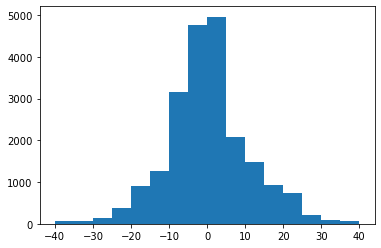

In [351]:
dvs = best_track[out_col].values[val_rank_indices[0]]
plt.hist(dvs, bins=np.arange(-40, 45, 5))

In [355]:
np.count_nonzero(best_track["dvmax_bt_24"].values[train_rank_indices[0]] > 30)

3210

In [356]:
best_track["dvmax_bt_24"].values[train_rank_indices[0]].size

27435

In [362]:
np.unique(best_track["STNAM"]  + best_track["STNUM"].astype(str)).size

123

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.500e+01,
        3.685e+03, 9.971e+03, 6.854e+03, 8.310e+02, 5.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,
         25,  30,  35,  40]),
 <a list of 16 Patch objects>)

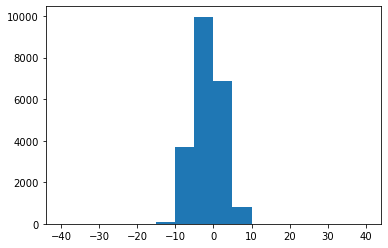

In [346]:
plt.hist(preds, bins=np.arange(-40, 45, 5))

In [309]:
norm_train_data[:, :, :, 1:].max()

1.0

In [343]:
np.mean(np.abs(best_track[out_col].values[train_rank_indices[0]].mean() - best_track[out_col].values[val_rank_indices[0]]))

8.433068883227365

In [332]:
fhours = best_track.loc[val_rank_indices[0], "TIME"].values
dvs = best_track[out_col].values[val_rank_indices[0]]
unique_fhours = np.unique(fhours)
maes = np.zeros(unique_fhours.shape)
for f, fh in enumerate(unique_fhours):
    idxs = fhours == fh
    print(fh, np.count_nonzero(idxs))
    maes[f] = skm.mean_absolute_error(dvs[idxs], preds.ravel()[idxs])

3 735
6 790
9 772
12 775
15 770
18 767
21 735
24 731
27 699
30 700
33 685
36 669
39 644
42 641
45 625
48 626
51 595
54 602
57 586
60 561
63 537
66 539
69 524
72 510
75 477
78 481
81 444
84 453
87 426
90 418
93 389
96 386
99 367
102 367
105 367
108 367
111 348
114 333


In [333]:
fhours = best_track.loc[train_rank_indices[0], "TIME"].values
dvs = best_track[out_col].values[train_rank_indices[0]]
unique_fhours = np.unique(fhours)
train_maes = np.zeros(unique_fhours.shape)
for f, fh in enumerate(unique_fhours):
    idxs = fhours == fh
    print(fh, np.count_nonzero(idxs))
    train_maes[f] = skm.mean_absolute_error(dvs[idxs], train_preds.ravel()[idxs])

3 897
6 965
9 949
12 989
15 959
18 970
21 945
24 937
27 897
30 887
33 851
36 848
39 798
42 809
45 797
48 777
51 753
54 755
57 726
60 722
63 686
66 691
69 651
72 642
75 616
78 615
81 592
84 588
87 560
90 549
93 533
96 531
99 509
102 496
105 502
108 501
111 473
114 469


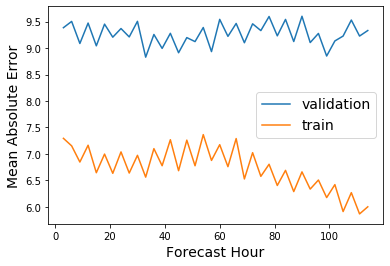

In [334]:
plt.plot(unique_fhours, maes, label="validation")
plt.plot(unique_fhours, train_maes, label="train")
plt.xlabel("Forecast Hour", fontsize=14)
plt.legend(fontsize=14)
plt.ylabel("Mean Absolute Error", fontsize=14)
plt.savefig("hour_mae.png", dpi=200, bbox_inches="tight")

In [70]:
np.intersect1d(bt_train_indices, bt_val_indices)

array([], dtype=int64)

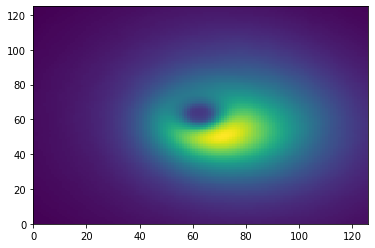

In [323]:
plt.pcolormesh(norm_train_data[:, :, :, 3].mean(axis=0))

In [335]:
np.corrcoef(best_track[out_col].values[val_rank_indices[0]], preds.ravel())

array([[1.        , 0.00646428],
       [0.00646428, 1.        ]])

/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


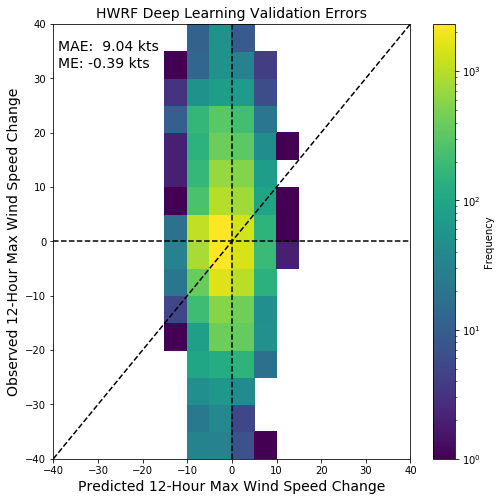

In [347]:
mae = skm.mean_absolute_error(best_track[out_col].values[val_rank_indices[0]], preds.ravel())
me = np.mean(best_track[out_col].values[val_rank_indices[0]] - preds.ravel())
dvs = best_track[out_col].values[val_rank_indices[0]]

plt.figure(figsize=(8, 8))
plt.hist2d(preds.ravel(), dvs, bins=np.arange(-40, 45, 5), cmin=1, norm=LogNorm())
diag = np.arange(-40, 45, 5)
plt.plot(diag, diag, 'k--')
plt.plot(np.zeros(diag.shape), diag, 'k--')
plt.plot(diag, np.zeros(diag.shape), 'k--')
plt.text(-39, 35, f"MAE: {mae: 0.2f} kts", fontsize=14)
plt.text(-39, 32, f"ME: {me: 0.2f} kts", fontsize=14)
plt.xlabel("Predicted 12-Hour Max Wind Speed Change", fontsize=14)
plt.ylabel("Observed 12-Hour Max Wind Speed Change", fontsize=14)
plt.colorbar(label="Frequency")
plt.title("HWRF Deep Learning Validation Errors", fontsize=14)
plt.savefig("hwrf_cnn_error_hist.png", dpi=200, bbox_inches="tight")

/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


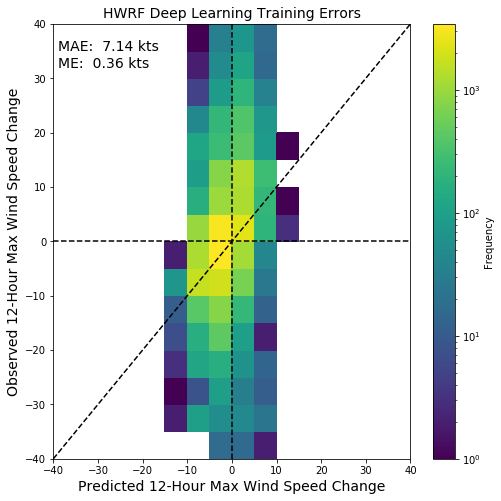

In [348]:
dvs = best_track[out_col].values[train_rank_indices[0]]
mae = skm.mean_absolute_error(dvs, train_preds.ravel())
me = np.mean(dvs - train_preds.ravel())

plt.figure(figsize=(8, 8))
plt.hist2d(train_preds.ravel(), dvs, bins=np.arange(-40, 45, 5), cmin=1, norm=LogNorm())
diag = np.arange(-40, 45, 5)
plt.plot(diag, diag, 'k--')
plt.plot(np.zeros(diag.shape), diag, 'k--')
plt.plot(diag, np.zeros(diag.shape), 'k--')
plt.text(-39, 35, f"MAE: {mae: 0.2f} kts", fontsize=14)
plt.text(-39, 32, f"ME: {me: 0.2f} kts", fontsize=14)
plt.xlabel("Predicted 12-Hour Max Wind Speed Change", fontsize=14)
plt.ylabel("Observed 12-Hour Max Wind Speed Change", fontsize=14)
plt.colorbar(label="Frequency")
plt.title("HWRF Deep Learning Training Errors", fontsize=14)
plt.savefig("hwrf_cnn_error_hist_train.png", dpi=200, bbox_inches="tight")

(-10, 160)

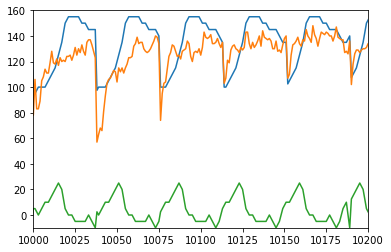

In [229]:
plt.plot(best_track["vmax_bt_new"])
plt.plot(best_track["VMAX"])

plt.plot(best_track["dvmax_bt_12"])
plt.xlim(10000, 10200)
plt.ylim(-10, 160)

In [217]:
atl_val_storms = best_track.loc[val_rank_indices[0], "BASIN"] == "e"
skm.mean_absolute_error(best_track.loc[val_rank_indices[0], out_col][atl_val_storms], preds[atl_val_storms])

10.790103017182513

In [213]:
atl_val_storms.shape

(1,)

In [148]:
out = (np.zeros((5, 30, 30)) - np.random.normal(size=(1, 30, 30)))

In [150]:
out[:, 0, 0]

array([-1.0766212, -1.0766212, -1.0766212, -1.0766212, -1.0766212])

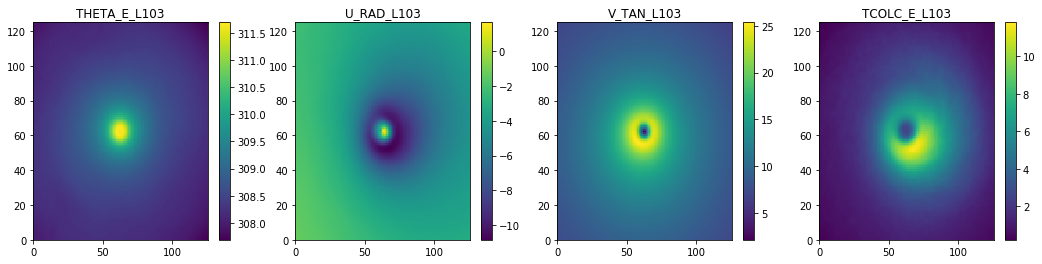

In [364]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for a, ax in enumerate(axes.ravel()):
    if a < train_data.shape[-1]:
        pc = ax.pcolormesh(np.nanmean(train_data[best_track.loc[train_rank_indices[0], out_col] > 12, :, :, a], axis=0),
                      )
        plt.colorbar(pc, ax=ax)
        ax.set_title(input_var_levels[a][0])

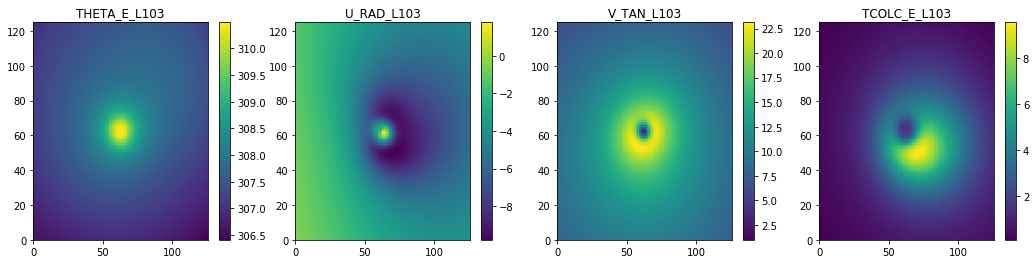

In [363]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for a, ax in enumerate(axes.ravel()):
    if a < train_data.shape[-1]:
        pc = ax.pcolormesh(np.nanmean(train_data[best_track.loc[train_rank_indices[0], out_col] < 12, :, :, a], axis=0),
                     )
        plt.colorbar(pc, ax=ax)
        ax.set_title(input_var_levels[a][0])

In [96]:
from sklearn.metrics import confusion_matrix

In [100]:
class ContingencyTable(object):
    """
    Initializes a binary contingency table and generates many skill scores.

    Args:
        a: true positives
        b: false positives
        c: false negatives
        d: true negatives

    Attributes:
        table (numpy.ndarray): contingency table
        N: total number of items in table

    """
    def __init__(self, a, b, c, d):
        self.table = np.array([[a, b], [c, d]], dtype=float)
        self.N = self.table.sum()

    def update(self, a, b, c, d):
        """
        Update contingency table with new values without creating a new object.
        """
        self.table.ravel()[:] = [a, b, c, d]
        self.N = self.table.sum()

    def __add__(self, other):
        """
        Add two contingency tables together and return a combined one.

        Args:
            other: Another contingency table

        Returns:
            Sum of contingency tables
        """
        sum_ct = ContingencyTable(*(self.table + other.table).tolist())
        return sum_ct

    def pod(self):
        """
        Probability of Detection (POD) or Hit Rate.
        Formula:  a/(a+c)
        """
        return self.table[0, 0] / (self.table[0, 0] + self.table[1, 0])

    def foh(self):
        """
        Frequency of Hits (FOH) or Success Ratio.
        Formula:  a/(a+b)
        """
        return self.table[0, 0] / (self.table[0, 0] + self.table[0, 1])

    def far(self):
        """
        False Alarm Ratio (FAR).
        Formula:  b/(a+b)
        """
        return self.table[0, 1] / (self.table[0, 0] + self.table[0, 1])

    def pofd(self):
        """
        Probability of False Detection (POFD).
        b/(b+d)
        """
        return self.table[0, 1] / (self.table[0, 1] + self.table[1, 1])

    def fom(self):
        """
        Frequency of Misses (FOM).
        Formula:  c/(a+c)."""
        return self.table[1, 0] / (self.table[0, 0] + self.table[1, 0])

    def dfr(self):
        """Returns Detection Failure Ratio (DFR).
           Formula:  c/(c+d)"""
        return self.table[1, 0] / (self.table[1, 0] + self.table[1, 1])

    def pon(self):
        """Returns Probability of Null (PON).
           Formula:  d/(b+d)"""
        return self.table[1, 1] / (self.table[0, 1] + self.table[1, 1])

    def focn(self):
        """Returns Frequency of Correct Null (FOCN).
           Formula:  d/(c+d)"""
        return self.table[1, 1] / (self.table[1, 0] + self.table[1, 1])

    def bias(self):
        """
        Frequency Bias.
        Formula:  (a+b)/(a+c)"""
        return (self.table[0, 0] + self.table[0, 1]) / (self.table[0, 0] + self.table[1, 0])

    def accuracy(self):
        """Finley's measure, fraction correct, accuracy (a+d)/N"""
        return (self.table[0, 0] + self.table[1, 1]) / self.N

    def csi(self):
        """Gilbert's Score or Threat Score or Critical Success Index a/(a+b+c)"""
        return self.table[0, 0] / (self.table[0, 0] + self.table[0, 1] + self.table[1, 0])

    def ets(self):
        """Equitable Threat Score, Gilbert Skill Score, v, (a - R)/(a + b + c - R), R=(a+b)(a+c)/N"""
        r = (self.table[0, 0] + self.table[0, 1]) * (self.table[0, 0] + self.table[1, 0]) / self.N
        return (self.table[0, 0] - r) / (self.table[0, 0] + self.table[0, 1] + self.table[1, 0] - r)

    def hss(self):
        """Doolittle (Heidke) Skill Score.  2(ad-bc)/((a+b)(b+d) + (a+c)(c+d))"""
        return 2 * (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / (
            (self.table[0, 0] + self.table[0, 1]) * (self.table[0, 1] + self.table[1, 1]) +
            (self.table[0, 0] + self.table[1, 0]) * (self.table[1, 0] + self.table[1, 1]))

    def pss(self):
        """Peirce (Hansen-Kuipers, True) Skill Score (ad - bc)/((a+c)(b+d))"""
        return (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / \
               ((self.table[0, 0] + self.table[1, 0]) * (self.table[0, 1] + self.table[1, 1]))

    def css(self):
        """Clayton Skill Score (ad - bc)/((a+b)(c+d))"""
        return (self.table[0, 0] * self.table[1, 1] - self.table[0, 1] * self.table[1, 0]) / \
               ((self.table[0, 0] + self.table[0, 1]) * (self.table[1, 0] + self.table[1, 1]))

    def __str__(self):
        table_string = '\tEvent\n\tYes\tNo\nYes\t%d\t%d\nNo\t%d\t%d\n' % (
            self.table[0, 0], self.table[0, 1], self.table[1, 0], self.table[1, 1])
        return table_string


In [102]:
cm = confusion_matrix(np.where(dvs > 0, 1, 0), np.where(preds.ravel() > 0, 1, 0))
ct = ContingencyTable(*cm.T.ravel().tolist())

In [106]:
dv_bin = np.where(dvs > 0, 1, 0) 
preds_bin = np.where(preds.ravel() > 0, 1, 0)
tp = np.count_nonzero((preds_bin == 1) & (dv_bin == 1))
fp = np.count_nonzero((preds_bin == 1) & (dv_bin == 0))
fn = np.count_nonzero((preds_bin == 0) & (dv_bin == 1))
tn = np.count_nonzero((preds_bin == 0) & (dv_bin == 0))

In [107]:
ct2 = ContingencyTable(tp, fp, fn, tn)

In [109]:
print(ct2)

	Event
	Yes	No
Yes	1706	2049
No	996	4634



In [116]:
ct2.pofd()

0.30659883285949424